In [ ]:
#### Imports 

In [13]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer, execute
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

#scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import QuantumKernel

### Load data

In [31]:
df = pd.read_csv('ai4i2020.csv')

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [41]:
#Only part of the dataset will be used
df = df.sample(200)

df

,TypeNum,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
1660,-1,298.2,308.0,1499,44.1,166,0
2841,-1,300.3,309.4,1705,29.4,190,0
479,0,297.4,308.9,1323,57.3,163,0
315,-1,297.9,308.4,1646,40.6,175,0
9423,-1,298.1,308.5,1676,30.5,22,0
...,...,...,...,...,...,...,...
8451,-1,298.5,310.0,1435,42.5,25,0
9924,0,298.5,308.6,1384,54.4,44,0
4802,0,303.5,312.4,1318,54.2,177,0
8351,0,298.7,309.6,1686,26.2,189,0


### Feature Preparation

In [42]:
dic = {'L' : -1, 'M' : 0, 'H'  : 1}

df['TypeNum'] = df['Type'].apply(lambda x : dic[x])

KeyError: 'Type'

In [43]:
features_labels = ['TypeNum', 'Air temperature [K]',
    'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
    'Tool wear [min]']
    
target_label = ['Machine failure']

df = df[features_labels + target_label]

### train-test split and standardize

In [44]:
sample_train, sample_test, target_train, target_test = train_test_split(
    df[features_labels], df[target_label], test_size=0.2, random_state=42)

#8000 for training, 2000 for testing

In [45]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_test = ss.transform(sample_test)

# Quantum SVM approach

In [46]:
shots = 10e03

feature_dimension = len(features_labels)
backend = Aer.get_backend('statevector_simulator')
feature_map = ZZFeatureMap(feature_dimension, reps = 2)

In [47]:
QKernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

example: parametric circuit for first two samples

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


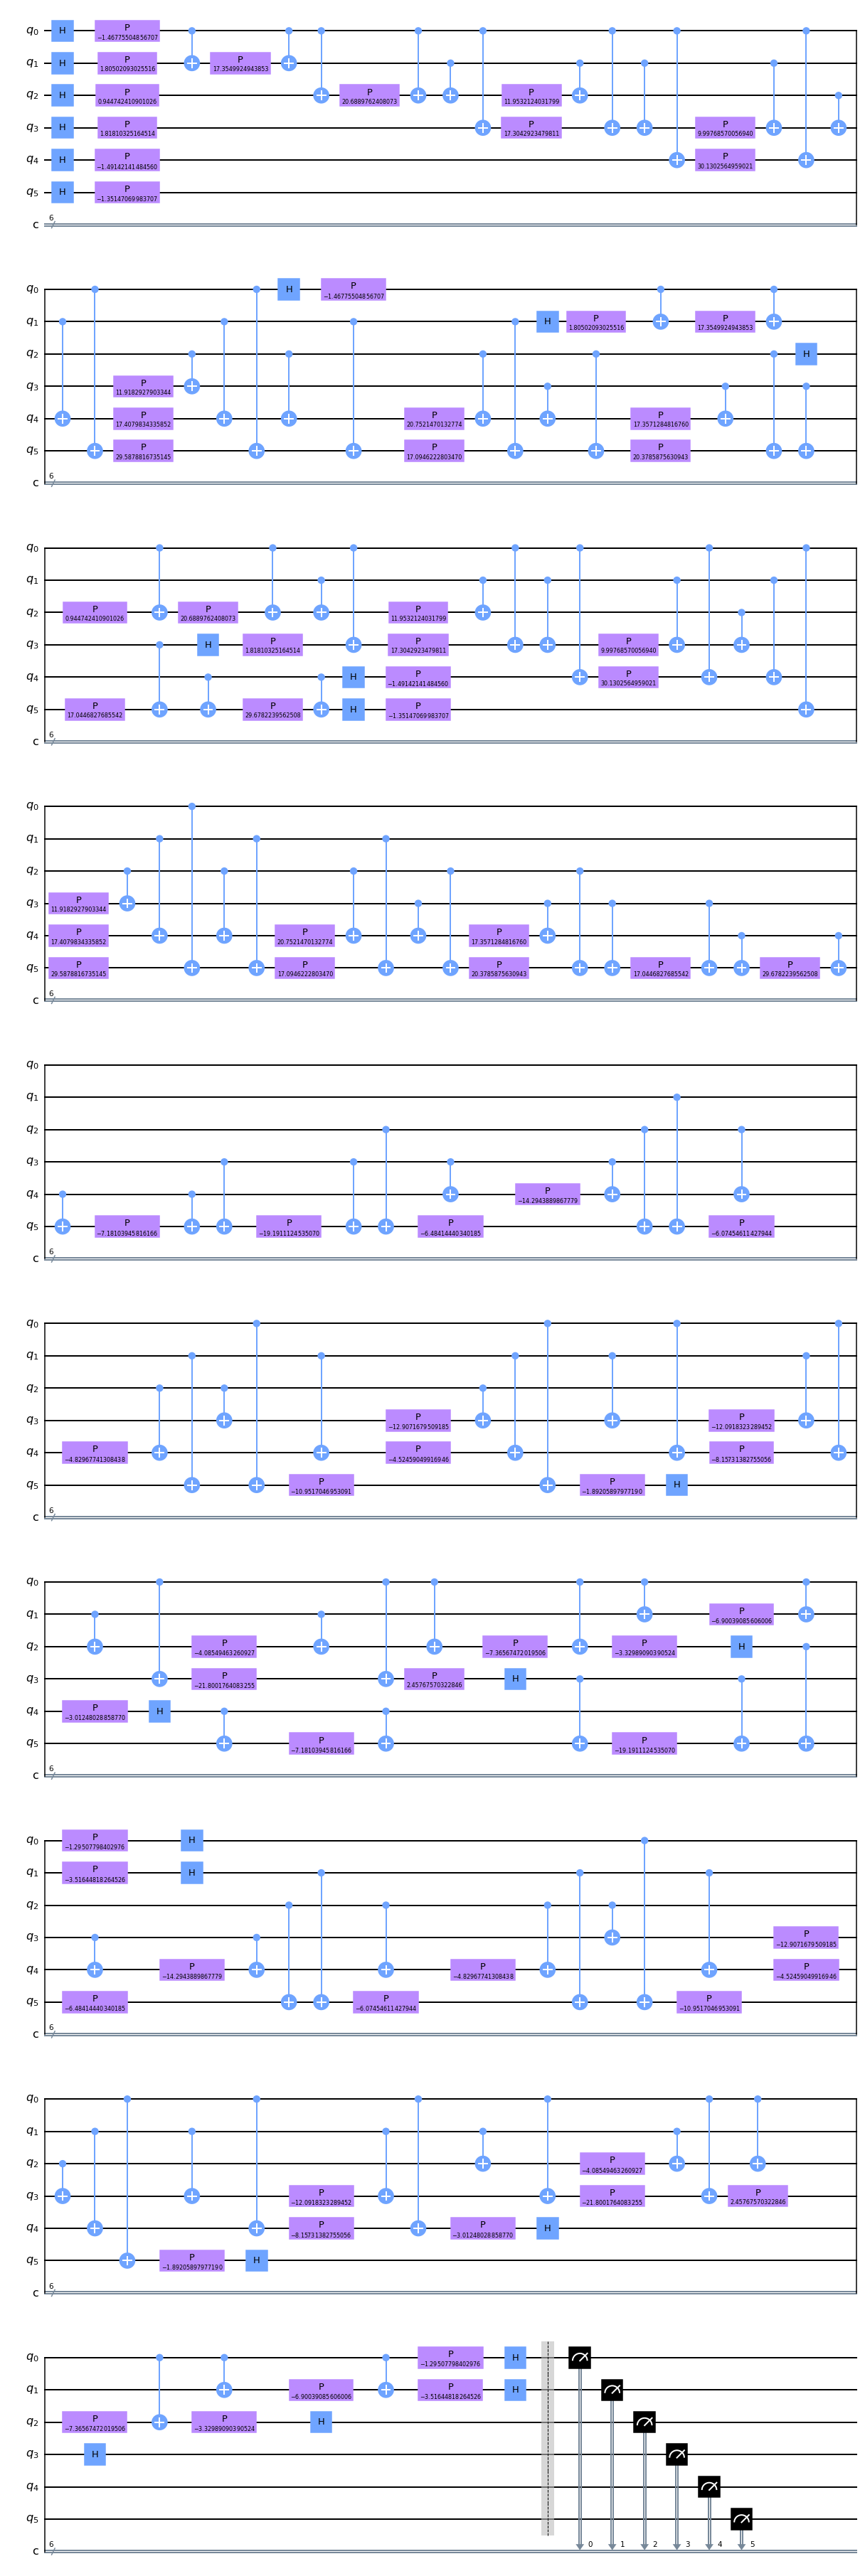

In [48]:
QKernel.construct_circuit(sample_train[0], sample_train[1]).decompose().decompose().draw(output= 'mpl')

let's run the QSVM

In [52]:
matrix_train = QKernel.evaluate(x_vec=sample_train)
matrix_test = QKernel.evaluate(x_vec=sample_test, y_vec=sample_train)

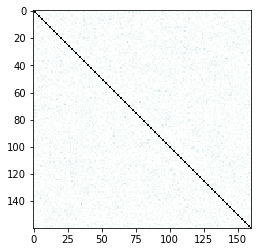

In [55]:
img = plt.imshow(np.asmatrix(matrix_train), interpolation = 'nearest', origin='upper', cmap = 'bone_r')

In [56]:
qsvc = SVC(kernel='precomputed')
qsvc.fit(matrix_train, target_train)
quantum_score = qsvc.score(matrix_test, target_test)

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
quantum_score

0.95